In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import plotly.graph_objects as go
from scipy.stats import shapiro, kstest
import scipy
from decimal import Decimal
import random

#### First of all, we want to quickly analyze the two data files of the two games to identify differences between each label.

In [22]:
# Loading datasets and converting them into dataframes

data1 = json.load(open('match_1.json'))
data2 = json.load(open('match_2.json'))
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

In [23]:
# Calculating several characteristics on the norm and the local maximums to normalize

df1['mean_norm'] = df1['norm'].apply(np.mean)
max_mean_norm = df1['mean_norm'].max()
df1['max_norm'] = df1['norm'].apply(np.max)
max_max_norm = df1['max_norm'].max()
df1['min_norm'] = df1['norm'].apply(np.min)
max_min_norm = df1['min_norm'].max()
df1['median_norm'] = df1['norm'].apply(np.median)
max_median_norm = df1['median_norm'].max()
df1['len_norm'] = df1['norm'].apply(len)
max_len_norm = df1['len_norm'].max()

In [24]:
# Putting local maximum values in a dictionary to be able to pass them in the for loop later

dict_max_metrics = {}
dict_max_metrics['mean_norm'] = max_mean_norm
dict_max_metrics['max_norm'] = max_max_norm
dict_max_metrics['min_norm'] = max_min_norm
dict_max_metrics['median_norm'] = max_median_norm
dict_max_metrics['len_norm'] = max_len_norm

In [25]:
# Building dictionaries to analyze the characteristics of each different label 

dict_data1_analysis = {}
dict_data1_analysis_normalized = {}
metrics = ['mean_norm', 'max_norm', 'min_norm', 'median_norm', 'len_norm']
labels = ['dribble', 'tackle', 'no action', 'shot', 'pass', 'cross', 'run', 'walk', 'rest']
for label in labels:
    dict_data1_analysis[label] = {}
    dict_data1_analysis_normalized[label] = {}
    for metric in metrics:
        dict_data1_analysis[label][metric] = df1[df1['label']==label][metric].mean()
        dict_data1_analysis_normalized[label][metric] = df1[df1['label']==label][metric].mean()/dict_max_metrics[metric]

In [26]:
# Plotting radar charts to be able to visualize the main differences on the selected characteristics

fig = go.Figure()
for label in labels:
    fig.add_trace(go.Scatterpolar(r=list(dict_data1_analysis_normalized[label].values()), theta=metrics, fill='toself', name=label))
fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 0.8])))
fig.show()

When looking at the radar plot, we can identify several specificities for each label:  
    - Shots have very high norm values and correspond to shorter sequences.    
    - Tackles have very high maximum values.  
    - Rest sequences correspond to longer sequences.  
    - Walks tend to have similar values compared to rests but with shorter sequences.  
    - Runs, dribbles and passes are very similar even though passes seem to have more important values.  
    - Crosses tend to have smaller minimum, median and mean values but with higher maximum values.  

#### Now we want to look at how we could generate new game data. 

The problem we are dealing with is a problem of generation of data. Based on the two examples of game data at our disposal, we have to generate a new game. Data generation problems are usually dealt with using generative adversarial networks (GANs), which are a class of unsupervised learning techniques. They are frequently used to generate images for instance. The idea is to build a new set of data thanks to one network and to train another network which has to discriminate data generated from the network and other data. In the context of generating acceleration norm values and corresponding labels, we could use a recurrent neural network (RNN) which allows to generate time-series data.  

However, before using such advanced techniques, we want to check if there is a way to generate this data more easily. The problem here is that we have relatively small samples of data to use neural network techniques, which usually require huge amounts of training data to be efficient. So the chosen method will be more statistically-based, using the data distributions that we have in the two example files, and it is explained as follows:  
1) We will draw a first label based on the frequency of the different labels.  
2) We will associate to this first label a list of norm values of length calculated according to the distribution of gait lengths for this label and of values calculated according to the distribution of values for this particular label in our original data.  
3) As long as the dictionary is not completely filled in, we will keep drawing labels according to the conditional probability based on the previous label, and associating lists of norm values.

#### First of all, we are going to look at the frequency of each action in each game.

In [7]:
len_game1 = len(data1)
sequences_game1 = [data1[i]['label'] for i in range(len_game1)]

In [8]:
len_game2 = len(data2)
sequences_game2 = [data2[i]['label'] for i in range(len_game2)]

In [9]:
for label in labels:
    print(label, sequences_game1.count(label)/len_game1)

dribble 0.07317073170731707
tackle 0.03484320557491289
no action 0.0
shot 0.010452961672473868
pass 0.041811846689895474
cross 0.005226480836236934
run 0.3641114982578397
walk 0.4268292682926829
rest 0.04355400696864112


In [10]:
for label in labels:
    print(label, sequences_game2.count(label)/len_game2)

dribble 0.05872756933115824
tackle 0.01794453507340946
no action 0.0032626427406199023
shot 0.01957585644371941
pass 0.013050570962479609
cross 0.0016313213703099511
run 0.5595432300163132
walk 0.3099510603588907
rest 0.01631321370309951


We can clearly identify differences between the two games provided. The first one probably corresponds to a more defensive player (less runs, more walks, more ball touches, less shots, more tackles, ...). 

In [11]:
# We store label frequencies in a dictionary that will allow us to draw the first label of our game.

dict_label_frequencies = {}
for label in labels:
    dict_label_frequencies[label] = (sequences_game1.count(label) + sequences_game2.count(label))/(len_game1 + len_game2)

In order to recreate the game, we are going to use the frequencies of each type of sequence, assuming that the nature of the next sequence only depends on the next one, which clearly is a simplification but will allow us to avoid having incoherent sequence runs.

In [12]:
# For each label in our dataframes, we add the label that follows to be able to calculate the conditional probability of each label based on the knowledge of the previous label.

n1 = len(sequences_game1)
n2 = len(sequences_game2)
df1['next_label'] = np.nan
df2['next_label'] = np.nan
for i in range(n1-1):
    df1['next_label'].iloc[i] = df1['label'].iloc[i+1]
for i in range(n2-1):
    df2['next_label'].iloc[i] = df2['label'].iloc[i+1]

C:\Users\pierr\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
# We store in a dictionary the frequency for which each label follows another label.

dict_next_sequence_label_frequency = {}
for label in labels:
    dict_next_sequence_label_frequency[label] = {}
    for next_label in labels:
        count = list(df1[df1['label']==label]['next_label'].values).count(next_label) + list(df2[df2['label']==label]['next_label'].values).count(next_label)
        length = len(df1[df1['label']==label]) + len(df2[df2['label']==label])
        dict_next_sequence_label_frequency[label][next_label] = count/length

In [14]:
# We store in a dictionary the norm values of each gait to study their distributions according to the corresponding label.

dict_regrouped_norms_by_label = {}
for label in labels:
    dict_regrouped_norms_by_label[label] = df1[df1['label']==label].explode('norm')['norm'].to_list() + df2[df2['label']==label].explode('norm')['norm'].to_list()

In [15]:
# We store in a dictionary the length of each gait to study their distributions according to the corresponding label.

dict_regrouped_lens_by_label = {}
df2['len_norm'] = df2['norm'].apply(len)
for label in labels:
    dict_regrouped_lens_by_label[label] = df1[df1['label']==label]['len_norm'].to_list() + df2[df2['label']==label]['len_norm'].to_list()

Text(0.5, 1.0, 'rest')

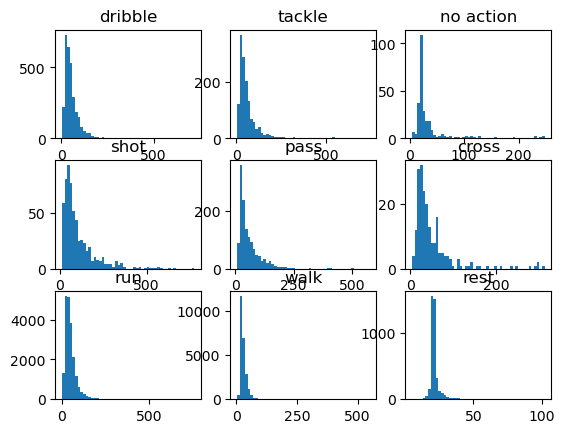

In [16]:
# We plot every norm value according to the label it is associated with.

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3)
ax1.hist(dict_regrouped_norms_by_label['dribble'], bins=50);
ax1.set_title('dribble')
ax2.hist(dict_regrouped_norms_by_label['tackle'], bins=50);
ax2.set_title('tackle')
ax3.hist(dict_regrouped_norms_by_label['no action'], bins=50);
ax3.set_title('no action')
ax4.hist(dict_regrouped_norms_by_label['shot'], bins=50);
ax4.set_title('shot')
ax5.hist(dict_regrouped_norms_by_label['pass'], bins=50);
ax5.set_title('pass')
ax6.hist(dict_regrouped_norms_by_label['cross'], bins=50);
ax6.set_title('cross')
ax7.hist(dict_regrouped_norms_by_label['run'], bins=50);
ax7.set_title('run')
ax8.hist(dict_regrouped_norms_by_label['walk'], bins=50);
ax8.set_title('walk')
ax9.hist(dict_regrouped_norms_by_label['rest'], bins=50);
ax9.set_title('rest')

Globally, the distributions really look like usual distribution laws such as gamma or normal laws. We are going to try and identify, for each label, which distribution is closest to the real data histograms, and use these laws to generate our new data. To do so, we define the find_best_distribution_law function which consists in an ordinary least squares regression using the mean squared error to find the closest probability density function compared to our data. The idea is to define a set of distribution laws to try out (here normal, beta, gamma, lognormal, inverse-gamma, inverse-gauss, alpha, chi2). For each of these laws, we estimate the specific parameters thanks to the fit method of scipy.stats, which operates a maximum likelihood estimation of these parameters.  
The maximum likelihood estimation is a statistical method which allows to find estimates of distribution law parameters. If we consider our data to be $X = (x_1, ..., x_n)$, where n is the sample size, we define $f(x∣θ)$ as the probability density function (pdf) of the underlying probability distribution, with $θ$ being the set of parameters specific to this pdf. It basically corresponds to the probability of observing x with the set of parameters θ. We then define the likelihood function, denoted as $L(θ∣X)$, and which corresponds to the probability of observing X given the parameter $θ$: $L(θ∣X)=\prod_{i=1}^n f(x_i∣θ)$. Often, we prefer working with the log-likelihood because it simplifies the calculations: $l(θ∣X)=log(L(θ∣X))$. Hence, we want to find the parameter values $θ$ that maximize the log-likelihood (or equivalently, the log-likelihood) function: 
$\hat{θ_{MLE}} = argmax_θ(l(θ∣X))$. Consequently, the problem that has to be resolved is the following: $\frac{\partial l}{\partial θ} = 0$. The maximum likelihood estimator is the most efficient unbiased estimator and its results are increasingly good according to the data sample size.  
Once the parameters have been found, we try out all distributions to see which one is closest to the original data. 

In [2]:
def find_best_distribution_law(label, threshold, dictionary, show_plot=False):
    dict_laws = {} # contains the distribution law parameters chosen for the label
    mse = np.inf # mean squared error initialization
    data = dictionary[label]
    y, x = np.histogram(data, bins=100, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    
    for name in DISTRIBUTION_NAMES:
        distribution = getattr(scipy.stats, name)
        param = distribution.fit(data)
        loc = param[-2]
        scale = param[-1]
        arg = param[:-2]
        pdf = distribution.pdf(x, *arg, loc=loc, scale=scale)
        current_mse = np.mean((y - pdf)**2)
        if current_mse < mse :
            best_pdf = pdf
            mse = current_mse
            best_loc = loc
            best_scale = scale
            best_arg = arg
            best_name = name
        if current_mse < threshold :
            break
            
    dict_laws['model'] = best_name
    dict_laws['loc'] = best_loc
    dict_laws['scale'] = best_scale
    dict_laws['other arguments'] = best_arg 
    dict_laws['mse'] = mse   
    
    if show_plot:
        plt.hist(data, label=label, density=True, bins=100)
        plt.plot(x, best_pdf, label=best_name, linewidth=3)
        plt.legend(loc='upper right')
        plt.text(np.mean(x), np.max(y), f'mse: {"%.2E" % Decimal(mse)}')
        plt.show()    
    
    return dict_laws

In [18]:
DISTRIBUTION_NAMES = ['norm', 'beta', 'gamma', 'lognorm', 'invgamma', 'invgauss', 'alpha', 'chi2']
MSE_THRESHOLD = 1e-7

C:\Users\pierr\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:684: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\pierr\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

C:\Users\pierr\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2781: RuntimeWarning:

invalid value encountered in double_scalars



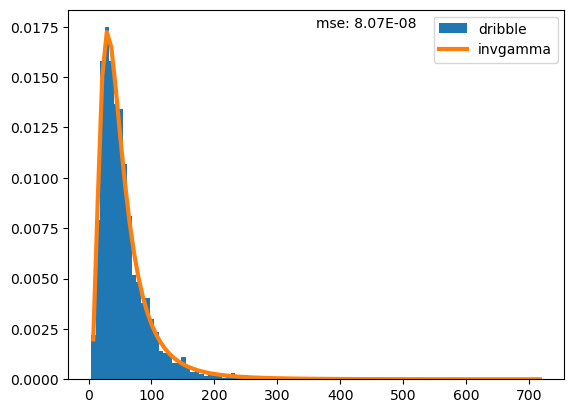

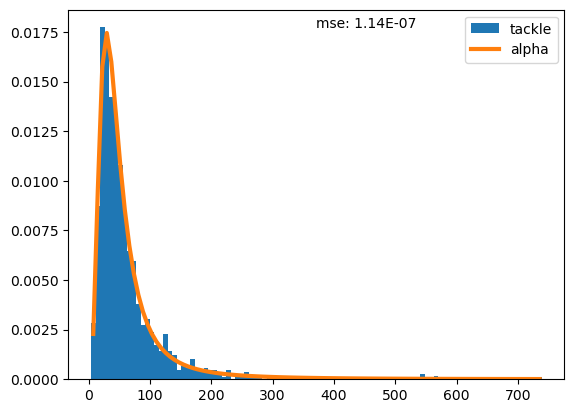

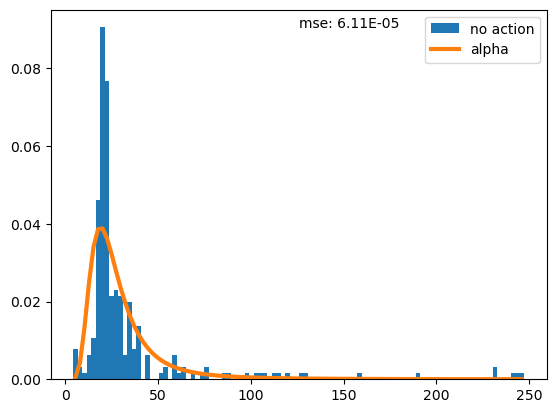

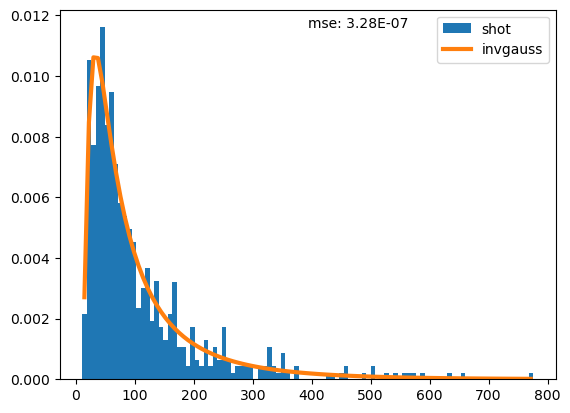

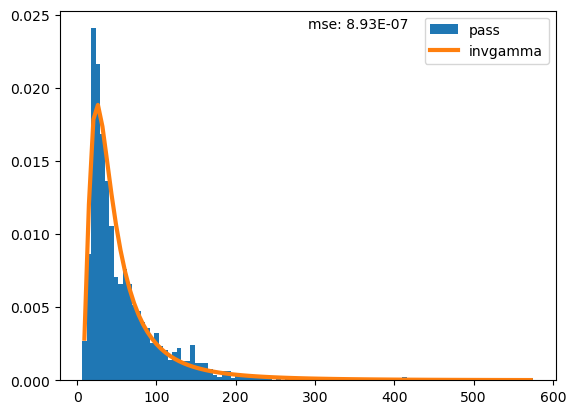

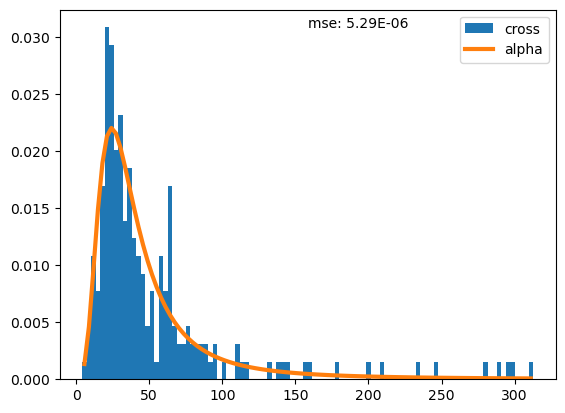

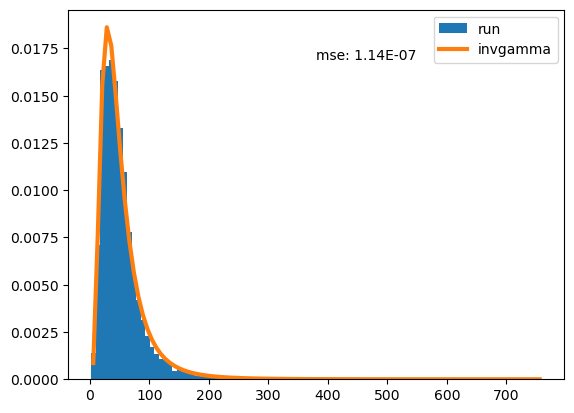

C:\Users\pierr\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.



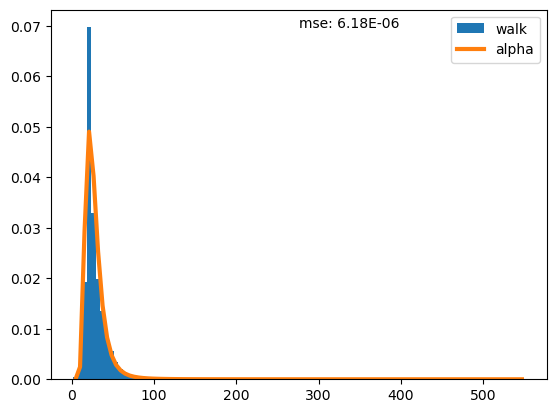

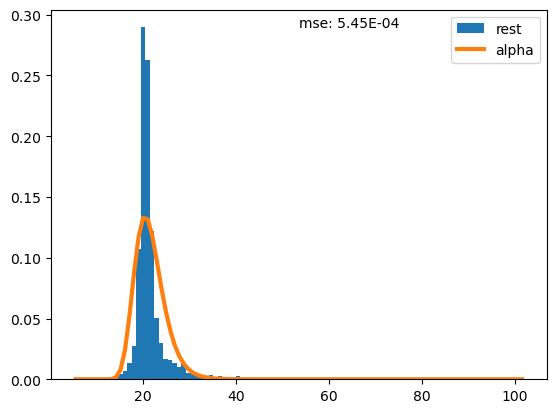

In [19]:
# We store the results in a dictionary we will be able to use to generate our game data.

dict_laws_norms = {}
for label in labels:
    dict_laws_norms[label] = find_best_distribution_law(label, MES_THRESHOLD, dict_regrouped_norms_by_label, show_plot=True)

Based on visuals, the pdf is credible for most sequence labels. For 'no action', 'cross' and 'rest' labels, the distributions are not so close to the data but we judge it sufficient for an approximation.  
We use the same principles to identify the laws that will allow us to generate the lengths of the gaits.

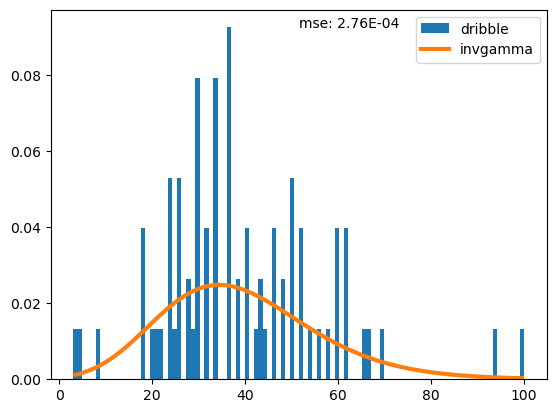

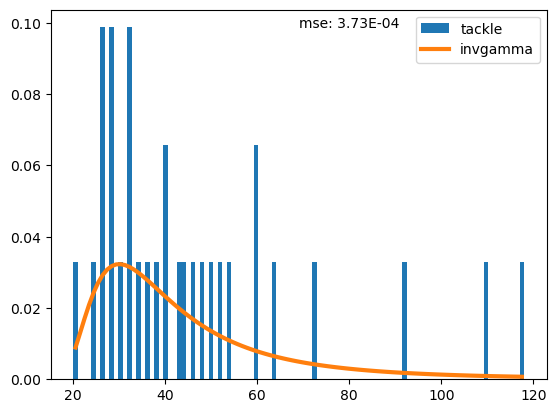

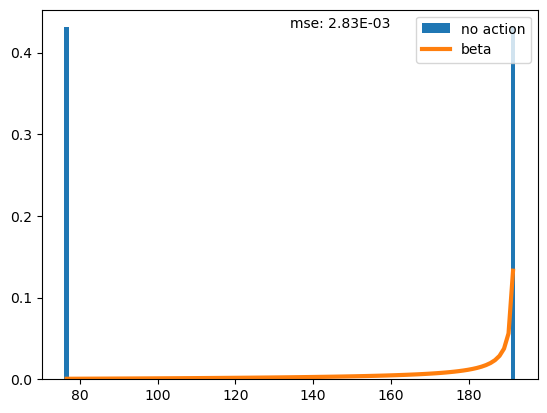

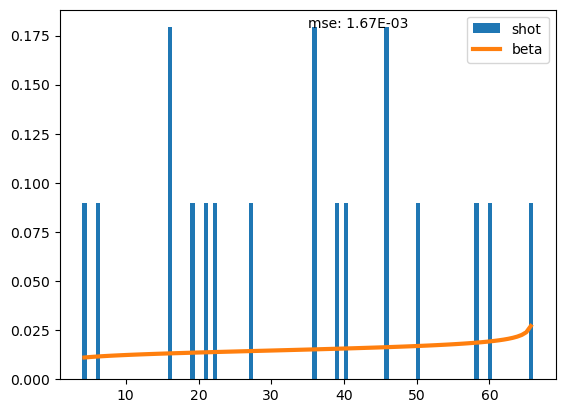

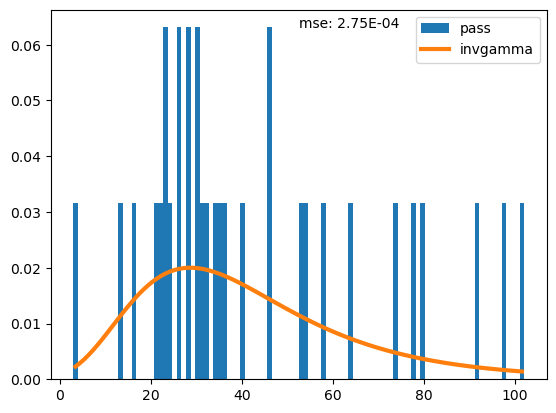

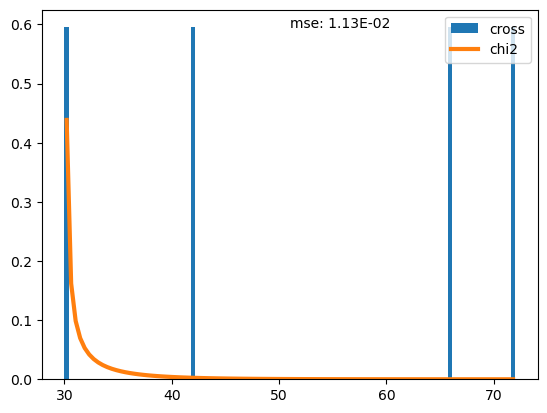

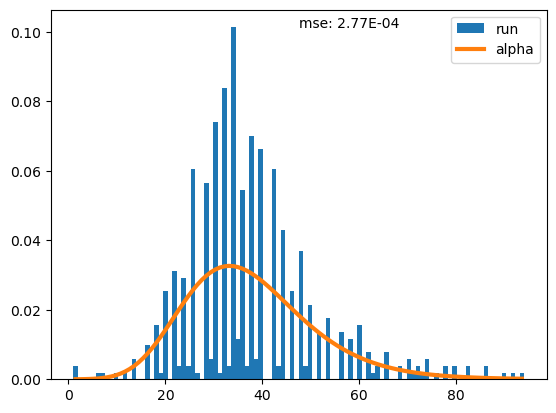

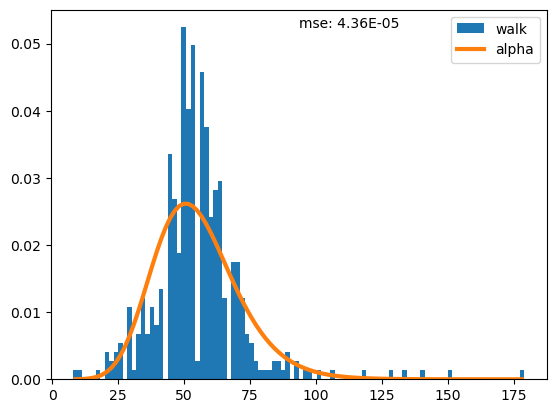

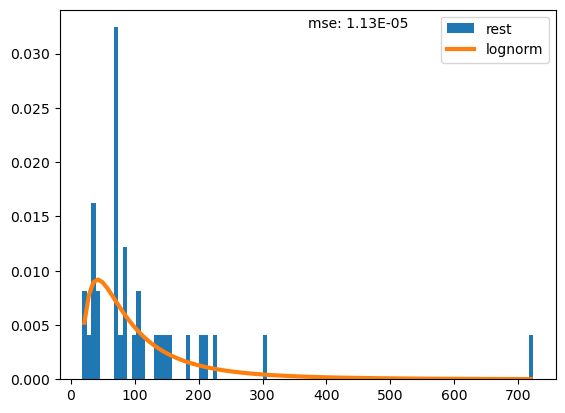

In [20]:
dict_laws_lens = {}
for label in labels:
    dict_laws_lens[label] = find_best_distribution_law(label, MSE_THRESHOLD, dict_regrouped_lens_by_label, show_plot=True)

For gait lengths, we are going to be less regarding than for values, because they inherently seem less statistically determined and we have less data available to work on. So when we see a data distribution that looks like a pattern (dribble, run, walk, rest), we are going to use the results from the dictionary but else we are simply going to take a random distribution between min and max values.

### The next section contains the final render. 

In [23]:
# We define the functions that will help us generating our new data in the main generation function.

def find_best_distribution_law(label, threshold, dictionary, show_plot=False):
    dict_laws = {} # contains the distribution law parameters chosen for the label
    mse = np.inf # mean squared error initialization
    data = dictionary[label]
    y, x = np.histogram(data, bins=100, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    
    for name in DISTRIBUTION_NAMES:
        distribution = getattr(scipy.stats, name)
        param = distribution.fit(data)
        loc = param[-2]
        scale = param[-1]
        arg = param[:-2]
        pdf = distribution.pdf(x, *arg, loc=loc, scale=scale)
        current_mse = np.mean((y - pdf)**2)
        if current_mse < mse :
            best_pdf = pdf
            mse = current_mse
            best_loc = loc
            best_scale = scale
            best_arg = arg
            best_name = name
        if current_mse < threshold :
            break
            
    dict_laws['model'] = best_name
    dict_laws['loc'] = best_loc
    dict_laws['scale'] = best_scale
    dict_laws['other arguments'] = best_arg 
    dict_laws['mse'] = mse   
    
    if show_plot:
        plt.hist(data, label=label, density=True, bins=100)
        plt.plot(x, best_pdf, label=best_name, linewidth=3)
        plt.legend(loc='upper right')
        plt.text(np.mean(x), np.max(y), f'mse: {"%.2E" % Decimal(mse)}')
        plt.show()    
    
    return dict_laws

def get_label_frequencies_from_data(data):
    # Get label frequencies according to original data
    sequences_games = [game['label'] for game in data for game in game]
    dict_label_frequencies = {}
    for label in LABELS:
        dict_label_frequencies[label] = sequences_games.count(label)/len(sequences_games)
    return dict_label_frequencies

def get_next_label_frequencies_from_data(df):
    # Get conditional probability of each label according to original data
    df['next_label'] = np.nan
    for i in range(len(df)-1):
        df['next_label'].iloc[i] = df['label'].iloc[i+1] if df['label'].iloc[i+1].index != 0 else np.nan # Case when these are two different games
    dict_next_sequence_label_frequency = {}
    for label in LABELS:
        dict_next_sequence_label_frequency[label] = {}
        for next_label in LABELS:
            count = list(df[df['label']==label]['next_label'].values).count(next_label)
            length = len(df[df['label']==label])
            dict_next_sequence_label_frequency[label][next_label] = count/length
    return dict_next_sequence_label_frequency

def get_norm_values_by_label(df):
    # Get all norm values by label from original data
    dict_regrouped_norms_by_label = {}
    for label in LABELS:
        dict_regrouped_norms_by_label[label] = df[df['label']==label].explode('norm')['norm'].to_list()
    return dict_regrouped_norms_by_label

def get_gait_lengths_by_label(df):
    # Get all gait lengths by label from original data
    dict_regrouped_lens_by_label = {}
    df['len_norm'] = df['norm'].apply(len)
    for label in LABELS:
        dict_regrouped_lens_by_label[label] = df[df['label']==label]['len_norm'].to_list()
    return dict_regrouped_lens_by_label
        
def process_original_data(original_data):
    # Regroups dictionnary calculations, which will allow our statistical treatment afterwards
    data = [json.load(open(file_name)) for file_name in original_data]
    df = pd.concat([pd.DataFrame(game) for game in data], ignore_index=False)
    dict_label_frequencies = get_label_frequencies_from_data(data)
    dict_next_sequence_label_frequency = get_next_label_frequencies_from_data(df)
    dict_regrouped_norms_by_label = get_norm_values_by_label(df)
    dict_regrouped_lens_by_label = get_gait_lengths_by_label(df)
    return dict_label_frequencies, dict_next_sequence_label_frequency, dict_regrouped_norms_by_label, dict_regrouped_lens_by_label

def update_label_probabilities(dictionary):
    new_probabilities_sum = sum(dictionary[label] for label in LABELS)
    for label in LABELS:
        dictionary[label] *= 1/new_probabilities_sum
    
def modify_label_probabilities(labels_to_modify, dict_label_frequencies, dict_next_sequence_label_frequency):
    for previous_label in LABELS:
        for label in labels_to_modify:
            dict_next_sequence_label_frequency[previous_label][label] *= 2
        update_label_probabilities(dict_next_sequence_label_frequency[previous_label])
    for label in labels_to_modify:
        dict_label_frequencies[label] *= 2
    update_label_probabilities(dict_label_frequencies)
    
def adapt_label_probabilities_to_game_type(dict_label_frequencies, dict_next_sequence_label_frequency, game_type):
    # Adapt label probabilities according to the type of game we want to generate
    if game_type == 'offensive':
        LABELS_TO_MODIFY = ['pass', 'shot', 'dribble']
        modify_label_probabilities(LABELS_TO_MODIFY, dict_label_frequencies, dict_next_sequence_label_frequency)
    elif game_type == 'defensive':
        LABELS_TO_MODIFY = ['rest', 'walk', 'tackle'] 
        modify_label_probabilities(LABELS_TO_MODIFY, dict_label_frequencies, dict_next_sequence_label_frequency)
    return dict_label_frequencies, dict_next_sequence_label_frequency

def generate_next_label(previous_label, dict_next_sequence_label_frequency):
    # Draw the next label based on the conditional probability of each label following the previous one.
    return random.choices(list(dict_next_sequence_label_frequency.keys()), weights=dict_next_sequence_label_frequency[previous_label].values())[0]
    
def generate_len_gait(label, t, nb_samples, dict_laws_lens, dict_regrouped_lens_by_label):
    # Draw the length of the gait
    if label in ['dribble', 'run', 'walk', 'rest']: # For labels for which we identified a pattern in the gait length, we use corresponding distributions
        distribution = getattr(scipy.stats, dict_laws_lens[label]['model'])
        return max(min(int(distribution.rvs(dict_laws_lens[label]['other arguments'][0], loc=dict_laws_lens[label]['loc'], scale=dict_laws_lens[label]['scale'])), nb_samples-t), 1)
    else: # For the other labels we randomly draw a length value between observed min and max 
        loc = np.min(dict_regrouped_lens_by_label[label])
        distribution = getattr(scipy.stats, 'uniform')
        return max(min(int(distribution.rvs(loc=loc, scale=np.max(dict_regrouped_lens_by_label[label])-loc)), nb_samples-t), 1)

def generate_gait_norm(label, len_gait, dict_laws_norms):
    # Draw the norm values for the gait
    distribution = getattr(scipy.stats, dict_laws_norms[label]['model'])
    return distribution.rvs(dict_laws_norms[label]['other arguments'][0], loc=dict_laws_norms[label]['loc'], scale=dict_laws_norms[label]['scale'], size=len_gait)

def reorder_norms(norms):
    # Reorder norms so that they are a little bit more continuous
    reordered_norms = [norms[0]]
    norms.remove(norms[0])
    gait_length = len(norms)
    for i in range(1, gait_length): # Loop to reorder values more coherently
        previous_value = reordered_norms[-1]
        closest_value = min(norms, key=lambda x: abs(x - previous_value))
        norms.remove(closest_value)
        reordered_norms.append(closest_value)
    shuffle_param = int(0.2*gait_length)
    for i in range(1, shuffle_param): # Loop to shuffle values to be less deterministic 
        a, b = random.randint(0, gait_length-1), random.randint(0, gait_length-1)
        reordered_norms[a], reordered_norms[b] = reordered_norms[b], reordered_norms[a]
    return reordered_norms

In [26]:
def generate_games(original_data, nb_of_games, game_length, mse_threshold, game_type='normal'):
    # Generate the desired number of games
    
    nb_samples = game_length*60*SAMPLING_FREQ
    
    ### Processing data and finding distribution laws ###
    dict_label_frequencies, dict_next_sequence_label_frequency, dict_regrouped_norms_by_label, dict_regrouped_lens_by_label = process_original_data(original_data)
    dict_label_frequencies, dict_next_sequence_label_frequency =  adapt_label_probabilities_to_game_type(dict_label_frequencies, dict_next_sequence_label_frequency, game_type)
    dict_laws_lens = {}
    dict_laws_norms = {}
    for label in LABELS:
        dict_laws_lens[label] = find_best_distribution_law(label, mse_threshold, dict_regrouped_lens_by_label, show_plot=False)
        dict_laws_norms[label] = find_best_distribution_law(label, mse_threshold, dict_regrouped_norms_by_label, show_plot=False)
    ### Generating games ###
    games = [] # List containing all generated games
    for game_nb in range(nb_of_games):
        game = [] # Initialize game 
        t = 0 # Initialize counter through the game
        game_labels = random.choices(list(dict_label_frequencies.keys()), weights=dict_label_frequencies.values()) # Randomly draw a first label based on the probabilities of each label
        len_first_gait = generate_len_gait(game_labels[0], t, nb_samples, dict_laws_lens, dict_regrouped_lens_by_label) # Generate first gait length
        while t < nb_samples:
            gait = {} # Initialize gait
            previous_label = game_labels[-1]
            gait['label'] = previous_label
            new_label = generate_next_label(previous_label, dict_next_sequence_label_frequency)
            game_labels.append(new_label) # Update sequence of labels with the new label
            gait_length = generate_len_gait(new_label, t, nb_samples, dict_laws_lens, dict_regrouped_lens_by_label) # Generate length of gait based on the label
            gait['norm'] = generate_gait_norm(new_label, gait_length, dict_laws_norms).tolist() # Generate gait norm values
            gait['norm'] = reorder_norms(gait['norm']) # Reorder norms to limit discontinuity
            t += gait_length # Updating game counter
            game.append(gait) # Updating game with new gait
        with open(f"game{game_nb}.json", "w") as outfile:
            outfile.write(json.dumps(game)) # Saving game as json file
        games.append(game)
    return games

In [27]:
SAMPLING_FREQ = 50
GAME_LENGTH = 60
NB_OF_GAMES = 5
ORIGINAL_DATA = ['match_1.json', 'match_2.json']
LABELS = ['dribble', 'tackle', 'no action', 'shot', 'pass', 'cross', 'run', 'walk', 'rest']
DISTRIBUTION_NAMES = ['norm', 'beta', 'gamma', 'lognorm', 'invgamma', 'invgauss', 'alpha', 'chi2']
MSE_THRESHOLD = 1e-7
GAME_TYPE = 'offensive'

games = generate_games(ORIGINAL_DATA, NB_OF_GAMES, GAME_LENGTH, MSE_THRESHOLD, game_type=GAME_TYPE)

{'dribble': {'dribble': 0.5, 'tackle': 0.0, 'no action': 0.0, 'shot': 0.08974358974358974, 'pass': 0.23076923076923078, 'cross': 0.038461538461538464, 'run': 0.10256410256410256, 'walk': 0.038461538461538464, 'rest': 0.0}, 'tackle': {'dribble': 0.12903225806451613, 'tackle': 0.22580645161290322, 'no action': 0.0, 'shot': 0.0, 'pass': 0.0, 'cross': 0.0, 'run': 0.4838709677419355, 'walk': 0.16129032258064516, 'rest': 0.0}, 'no action': {'dribble': 0.0, 'tackle': 0.0, 'no action': 0.0, 'shot': 0.0, 'pass': 0.0, 'cross': 0.0, 'run': 0.5, 'walk': 0.5, 'rest': 0.0}, 'shot': {'dribble': 0.05555555555555555, 'tackle': 0.0, 'no action': 0.05555555555555555, 'shot': 0.3333333333333333, 'pass': 0.0, 'cross': 0.0, 'run': 0.2222222222222222, 'walk': 0.3333333333333333, 'rest': 0.0}, 'pass': {'dribble': 0.125, 'tackle': 0.0, 'no action': 0.0, 'shot': 0.0, 'pass': 0.15625, 'cross': 0.03125, 'run': 0.28125, 'walk': 0.3125, 'rest': 0.09375}, 'cross': {'dribble': 0.0, 'tackle': 0.0, 'no action': 0.0, 's